Datasets + importing data 


In [ ]:
import urllib.request
import os 
urllib.request.urlretrieve('https://www.google.com/images/branding/googlelogo/1x/googlelogo_color_272x92dp.png', 'google.png')
os.listdir()

['.config', 'google.png', 'sample_data']

In [ ]:
import os 

if not os.path.exists('./cyclegan'):
  os.makedirs('./cyclegan')
  %cd /content/cyclegan/

if not os.path.exists('./download'):
  os.makedirs('./download')
  os.chdir('./download')
  !wget http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/vangogh2photo.zip
  !unzip vangogh2photo.zip -d ''
  

Streaming output truncated to the last 5000 lines.
  inflating: vangogh2photo/trainB/2016-08-26 19:25:29.jpg  
  inflating: vangogh2photo/trainB/2016-02-20 16:54:25.jpg  
  inflating: vangogh2photo/trainB/2015-05-19 19:43:44.jpg  
  inflating: vangogh2photo/trainB/2015-10-26 21:18:58.jpg  
  inflating: vangogh2photo/trainB/2014-07-19 15:39:53.jpg  
  inflating: vangogh2photo/trainB/2015-06-13 21:21:54.jpg  
  inflating: vangogh2photo/trainB/2015-06-04 14:10:33.jpg  
  inflating: vangogh2photo/trainB/2014-06-18 12:46:34.jpg  
  inflating: vangogh2photo/trainB/2016-03-17 18:07:22.jpg  
  inflating: vangogh2photo/trainB/2015-01-24 17:24:29.jpg  
  inflating: vangogh2photo/trainB/2016-01-27 12:45:41.jpg  
  inflating: vangogh2photo/trainB/2016-06-14 05:57:28.jpg  
  inflating: vangogh2photo/trainB/2015-12-24 01:48:36.jpg  
  inflating: vangogh2photo/trainB/2015-10-18 05:19:51.jpg  
  inflating: vangogh2photo/trainB/2015-01-23 07:43:34.jpg  
  inflating: vangogh2photo/trainB/2016-04-29 18:0

In [ ]:
import torch 
from torchvision import datasets 
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = (256, 256)
BATCH_SIZE = 1

data_dir = os.path.join(os.getcwd(),'cyclegan/download/vangogh2photo')

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir 
        self.transform = transform 
        all_imgs = os.listdir(main_dir) #get all directories in direcotr y
        self.total_imgs = all_imgs

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image) 
        return tensor_image 

def customDataloader(data_dir):
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE), 
        transforms.ToTensor(), 
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ])

    dataset = CustomDataSet(main_dir = data_dir, transform = transform)
    train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    #download items 
    return train_dataloader

Create the model of the network 

In [ ]:
from re import L
import torch
import torch.nn as nn 
import torch.nn.functional as F 
!pip install torchinfo
from torchinfo import summary

class ResBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        """ResBlock based on CycleGAN Paper implementation"""
        super(ResBlock, self).__init__()
        self.input = input_channels 
        self.output = output_channels
        self.model = nn.Sequential(
            nn.ReflectionPad2d(1), 
            nn.Conv2d(self.input, self.output, 3, stride = 1), 
            nn.InstanceNorm2d(self.output), 
            nn.ReLU(True), 
            nn.ReflectionPad2d(1), 
            nn.Conv2d(self.output, self.output, 3, 1), 
            nn.InstanceNorm2d(self.output)
        )
    def forward(self, x):
        return x + self.model(x)

class Generator(nn.Module):
    """Similar Implementation based on Original Paper"""
    def __init__(self):
        super(Generator, self).__init__()
        self.model = self.generator()

    def cinr(self, in_channels, out_channels, kernel_size, stride, padding = 0):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride = stride, padding = padding), 
        nn.InstanceNorm2d(out_channels), nn.ReLU(True)]
        return layers
    
    def fcinr(self, in_channels, out_channels, kernel_size, stride, padding = 1, output_padding = 1):
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding = padding, 
        output_padding = output_padding), 
        nn.InstanceNorm2d(out_channels), nn.ReLU(True)]
        return layers

    def generator(self, numRes = 5):
        layers = [nn.ReflectionPad2d(3)]
        layers += self.cinr(3, 64, 7, 1)
        ##downsampling
        layers.extend(self.cinr(64, 128, 3, 2, padding = 1))
        layers.extend(self.cinr(128, 256, 3, 2, padding = 1))
        ## add the ResBlocks (6) 
        for i in range(numRes):
            layers.append(ResBlock(256, 256))
        ##upsampling 
        layers.extend(self.fcinr(256, 128, 3, 2))
        layers.extend(self.fcinr(128, 64, 3, 2))

        layers += [nn.ReflectionPad2d(3)]
        layers.extend(self.cinr(64, 3, 7, 1))
        layers += [nn.Tanh()]
        
        return nn.Sequential(*layers)

    def forward(self, x): 
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__() 
        self.model = self.pathGAN()

    def pathGAN(self):
        layers = [
            nn.Conv2d(3, 64, 1, 1), 
            nn.LeakyReLU(0.2, True), 
            nn.Conv2d(64, 128, kernel_size = 1, stride = 1),
            nn.InstanceNorm2d(128), 
            nn.LeakyReLU(0.2, True), 
            nn.Conv2d(128, 1, 1, 1)
        ]
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

# model = Discriminator() 
# batch_size = 1
# summary(model, input_size = (1, 3, 256, 256))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch 
import torch.nn as nn 
import itertools

def adversarial_loss():
    return nn.MSELoss()

def cycle_loss():
    return nn.L1Loss()

def models():
    Gen_A = Generator().to(device)
    Gen_B = Generator().to(device)
    D_A = Discriminator().to(device)
    D_B = Discriminator().to(device)

    return Gen_A, Gen_B, D_A, D_B 
    
def createTargetTensor(prediction, target):
    target_tensor = torch.tensor(target)
    return target_tensor.expand_as(prediction)

def train(epochs = 10):
    ## create datasets 
    data_dir = os.path.join(os.getcwd(),'vangogh2photo')

    trainA = customDataloader(data_dir + '/trainA')
    trainB = customDataloader(data_dir + '/trainB')
    G_A, G_B, D_A, D_B = models()
    G_A.to(device)
    G_B.to(device)
    D_A.to(device)
    D_B.to(device)
    optimizer_G = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()))
    optimizer_D = torch.optim.Adam(itertools.chain(D_A.parameters(), D_B.parameters()))

    for n in range(epochs):
      Gen_A_Loss = [] 
      Gen_B_Loss = []
      Dis_A_Loss = []
      Dis_B_Loss = []
      for i, (input_a, input_b) in enumerate(zip(trainA, trainB)):
          input_a = input_a.to(device)
          input_b = input_b.to(device)
          ##pass through data in the models 
          fake_B = G_A(input_a)
          fake_A = G_B(input_b)
          rec_A = G_B(fake_B)
          rec_B = G_A(fake_A)
          ## calculate generator loss 
          D_A.requires_grad_(False)
          D_B.requires_grad_(False)
          
          optimizer_G.zero_grad() 
          prediction = D_A(fake_B).to(device)
          advloss_G_A = adversarial_loss()(prediction, createTargetTensor(prediction, 1.0).to(device)) 
          cycleLoss_G_A = cycle_loss()(input_a, rec_A)

          prediction = D_B(fake_A)
          advloss_G_B = adversarial_loss()(prediction, createTargetTensor(prediction, 1.0).to(device)) 
          cycleLoss_G_B = cycle_loss()(input_b, rec_B)

          totLoss_G_A = advloss_G_A + cycleLoss_G_A 
          totLoss_G_B = advloss_G_B + cycleLoss_G_B 

          totLoss_G_A.backward() 
          totLoss_G_B.backward() 

          optimizer_G.step() 

          D_A.requires_grad_(True)
          D_B.requires_grad_(True)

          ##pass through data in the models 
          fake_B = G_A(input_a) 
          fake_A = G_B(input_b)
          rec_A = G_B(fake_B) 
          rec_B = G_A(fake_A) 

          optimizer_D.zero_grad()

          real = D_A(input_b)
          disLoss_A = adversarial_loss()(real, createTargetTensor(real, 1.0).to(device))
          fake = D_A(fake_B)
          disLoss_A += adversarial_loss()(fake, createTargetTensor(fake, 0.0).to(device))
          total_A_Loss = disLoss_A * 0.5
          real = D_B(input_a)
          fake = D_B(fake_A)
          disLoss_B = adversarial_loss()(real, createTargetTensor(real, 1.0).to(device))
          disLoss_B += adversarial_loss()(fake, createTargetTensor(fake, 0.0).to(device))
          total_B_Loss = disLoss_B * 0.5
          
          total_A_Loss.backward() 
          total_B_Loss.backward()

          optimizer_D.step()
          if i % 50 == 0:
            print(f'G_A Loss: {totLoss_G_A} | G_B Loss: {totLoss_G_B} | D_A Loss: {total_A_Loss} | D_B Loss: {total_B_Loss}')
            Gen_A_Loss.append(totLoss_G_A)
            Gen_B_Loss.append(totLoss_G_B)
            Dis_A_Loss.append(total_A_Loss)
            Dis_B_Loss.append(total_B_Loss)

    Loss = {Gen_A_Loss, Gen_B_Loss, Dis_A_Loss, Dis_B_Loss}
    return G_A, G_B, D_A, D_B, Loss

G_A, G_B, D_A, D_B, Loss = train()

G_A Loss: 1.2705413103103638 | G_B Loss: 1.5656557083129883 | D_A Loss: 0.37826433777809143 | D_B Loss: 0.45682284235954285
G_A Loss: 0.7049086689949036 | G_B Loss: 0.7690173387527466 | D_A Loss: 0.2596223056316376 | D_B Loss: 0.24634376168251038
G_A Loss: 0.719846785068512 | G_B Loss: 1.2156727313995361 | D_A Loss: 0.3174290657043457 | D_B Loss: 0.2394183725118637
G_A Loss: 0.8859567046165466 | G_B Loss: 0.7616510391235352 | D_A Loss: 0.24105972051620483 | D_B Loss: 0.23613786697387695
G_A Loss: 0.7710884809494019 | G_B Loss: 0.7612175941467285 | D_A Loss: 0.23405826091766357 | D_B Loss: 0.22264742851257324
G_A Loss: 0.8197749853134155 | G_B Loss: 1.0556615591049194 | D_A Loss: 0.23298269510269165 | D_B Loss: 0.1826571822166443
G_A Loss: 0.8115884065628052 | G_B Loss: 0.6921401023864746 | D_A Loss: 0.22278153896331787 | D_B Loss: 0.22894395887851715
G_A Loss: 0.8012299537658691 | G_B Loss: 0.8063598871231079 | D_A Loss: 0.21533021330833435 | D_B Loss: 0.19100067019462585
G_A Loss: 0.7

TypeError: ignored

In [ ]:
print(G_A)

NameError: ignored

In [ ]:
def to_np(x):
    return x.data.cpu().numpy()
def plot_train_result(real_image, gen_image, recon_image, epoch, save=False, show=True, fig_size=(15, 15)):
    fig, axes = plt.subplots(2, 3, figsize=fig_size)
    imgs = [to_np(real_image[0]), to_np(gen_image[0]), to_np(recon_image[0]),
            to_np(real_image[1]), to_np(gen_image[1]), to_np(recon_image[1])]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        #ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Epoch {0}'.format(epoch + 1)
    fig.text(0.5, 0.04, title, ha='center')
    plt.show()

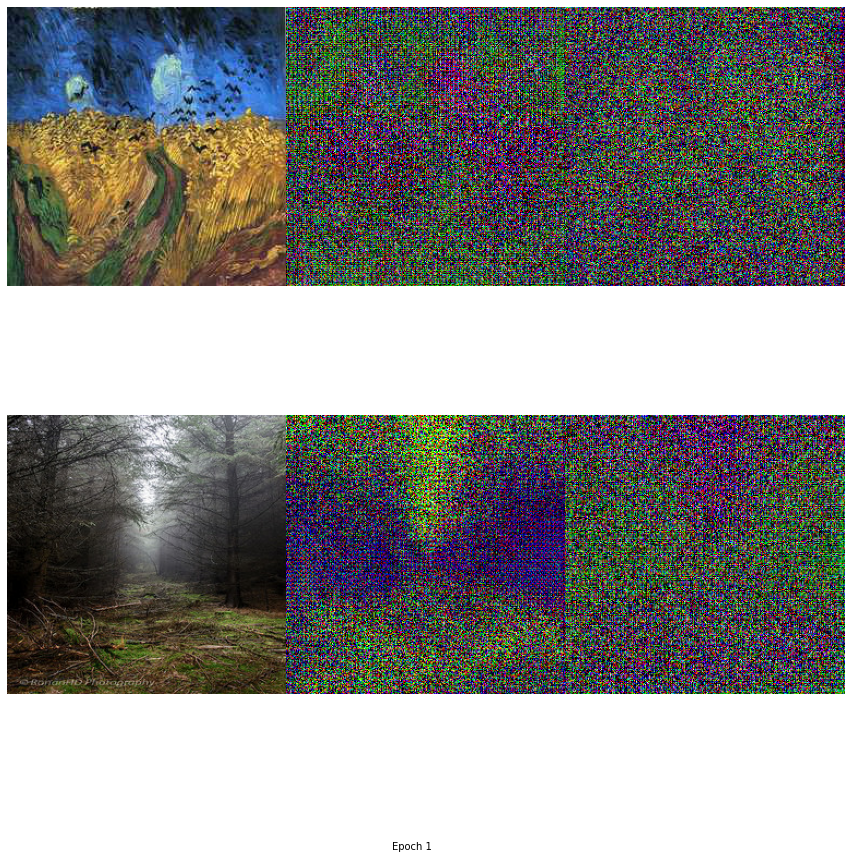

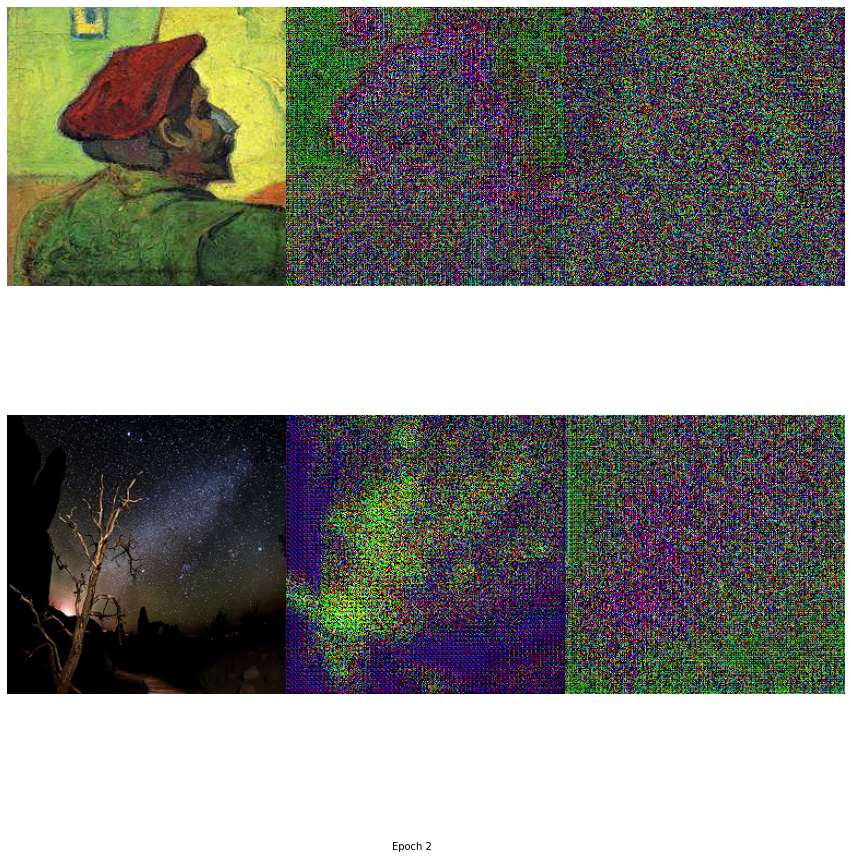

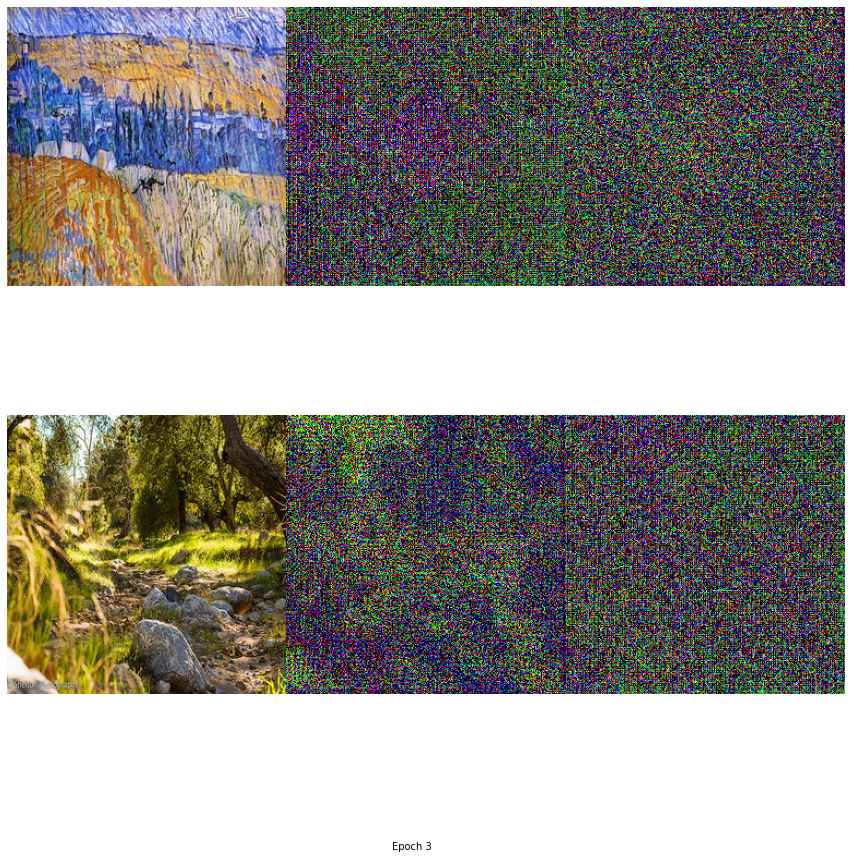

In [ ]:
count = 0
data_dir = os.path.join(os.getcwd(),'vangogh2photo')
testA = customDataloader(data_dir + '/testA')
testB = customDataloader(data_dir + '/testB')
G_A, G_B, D_A, D_B = models()
for i, (real_A, real_B) in enumerate(zip(testA, testB)):
    if(count<3):
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        fake_B = G_A(real_A)
        test_recon_A = G_B(fake_B)

        fake_A = G_B(real_B)
        test_recon_B = G_A(fake_A)

        plot_train_result([real_A, real_B], [fake_B, fake_A], [test_recon_A, test_recon_B],count, save = False)
        count = count+1
    else:
        break